##  Load and Preprocess the Dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import clip
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam

# Load CLIP model and preprocessing function
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("ViT-B/32", device)

# Define function to load images and labels from the directory
def load_images_and_labels(directory):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            label = int(filename.split('_')[1])  # Extract label (0 or 1)
            image_path = os.path.join(directory, filename)
            image = preprocess(Image.open(image_path)).unsqueeze(0)
            images.append(image)
            labels.append(label)
    return torch.cat(images), np.array(labels)

# Load train and test sets
train_images, train_labels = load_images_and_labels("D:\\RESEARCH_WORK\\Teeth_Segmentation_Project\\Train")
test_images, test_labels = load_images_and_labels("D:\\RESEARCH_WORK\\Teeth_Segmentation_Project\\Test")

# Split train set into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)


D:\CSE299\Flutter\Anaconda\envs\Research\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Training set shape: torch.Size([456, 3, 224, 224]) (456,)
Validation set shape: torch.Size([114, 3, 224, 224]) (114,)


## Class Distribution Visualization

C:\Users\Salem Shamsul Alam\AppData\Local\Temp\ipykernel_13984\3028316250.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts, palette='viridis')


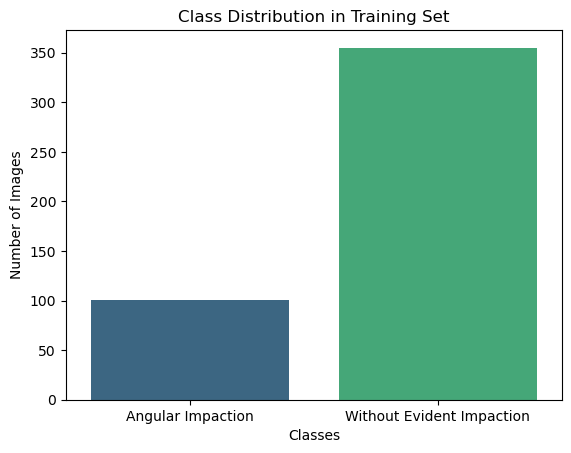

In [2]:
# Visualize class distribution in the training set
def plot_class_distribution(labels, class_names, save_path='class_distribution.png'):
    unique, counts = np.unique(labels, return_counts=True)
    sns.barplot(x=class_names, y=counts, palette='viridis')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution in Training Set')
    plt.savefig(save_path)
    plt.show()

class_names = ['Angular Impaction', 'Without Evident Impaction']
plot_class_distribution(train_labels, class_names)


##  Feature Extraction Using CLIP

In [3]:
# Function to preprocess images before feature extraction
def preprocess_images(images):
    processed_images = []
    for image in images:
        # Ensure images are in the correct format for CLIP (PIL)
        if isinstance(image, torch.Tensor):
            image = image.cpu().numpy().transpose(1, 2, 0)  # Convert from [C, H, W] to [H, W, C]

        # Convert the NumPy array to a PIL Image
        image = Image.fromarray((image * 255).astype(np.uint8))  # Ensure correct scaling if necessary

        # Apply the CLIP preprocessing
        image = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension and move to device
        processed_images.append(image)
    
    return torch.cat(processed_images)

# Function to extract features using CLIP
def extract_clip_features(images):
    features = []
    with torch.no_grad():
        images = preprocess_images(images)
        features = clip_model.encode_image(images)
        features = features.cpu().numpy()
    return features

# Extract features for training, validation, and test sets
train_features = extract_clip_features(train_images)
val_features = extract_clip_features(val_images)
test_features = extract_clip_features(test_images)

# Normalize the features
train_features /= np.linalg.norm(train_features, axis=1, keepdims=True)
val_features /= np.linalg.norm(val_features, axis=1, keepdims=True)
test_features /= np.linalg.norm(test_features, axis=1, keepdims=True)


## Random Oversampler

In [4]:
# Apply Random Oversampling to balance the training set
from imblearn.over_sampling import RandomOverSampler

# Initialize the oversampler
oversampler = RandomOverSampler(random_state=42)

# Reshape the feature arrays to be 2D (samples, features) if necessary
train_features = train_features.reshape(train_features.shape[0], -1)

# Apply oversampling to the training data
train_features, train_labels = oversampler.fit_resample(train_features, train_labels)

# Check class distribution after oversampling
print("New training set class distribution:", np.bincount(train_labels))

New training set class distribution: [355 355]


##  Create the CNN Model

In [5]:
from tensorflow.keras.layers import BatchNormalization

def create_cnn_model(input_shape=(512,)):
    # Define a simple CNN model on top of CLIP features
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = BatchNormalization()(x)  # Stabilizes training
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)  # Stabilizes training
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)  # Additional dense layer
    x = BatchNormalization()(x)  # Stabilizes training
    x = Dropout(0.2)(x)  # Optional dropout
    output = Dense(1, activation='sigmoid')(x)  # Binary classification
    model = Model(inputs, output)
    return model

# Create the CNN model
cnn_model = create_cnn_model(input_shape=(train_features.shape[1],))
cnn_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 174,337 (681.00 KB)

 Trainable params: 173,441 (677.50 KB)

 Non-trainable params: 896 (3.50 KB)

## Train the Model

In [6]:
# Train the model with extracted features
history = cnn_model.fit(
    train_features, train_labels,
    validation_data=(val_features, val_labels),
    epochs=20,
    batch_size=32
)


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5164 - loss: 0.9184 - val_accuracy: 0.7368 - val_loss: 0.6800
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5351 - loss: 0.8889 - val_accuracy: 0.7368 - val_loss: 0.6614
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5299 - loss: 0.8932 - val_accuracy: 0.7368 - val_loss: 0.6501
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5857 - loss: 0.7627 - val_accuracy: 0.7368 - val_loss: 0.6425
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5594 - loss: 0.8066 - val_accuracy: 0.7368 - val_loss: 0.6404
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5780 - loss: 0.7344 - val_accuracy: 0.7368 - val_loss: 0.6416
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5908 - loss: 0.7420 - val_accuracy: 0.7368 - val_loss: 0.6457
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6024 - loss: 0.7107 - val_accuracy: 0.7368 - val_loss

## Plot Accuracy and Loss Curves

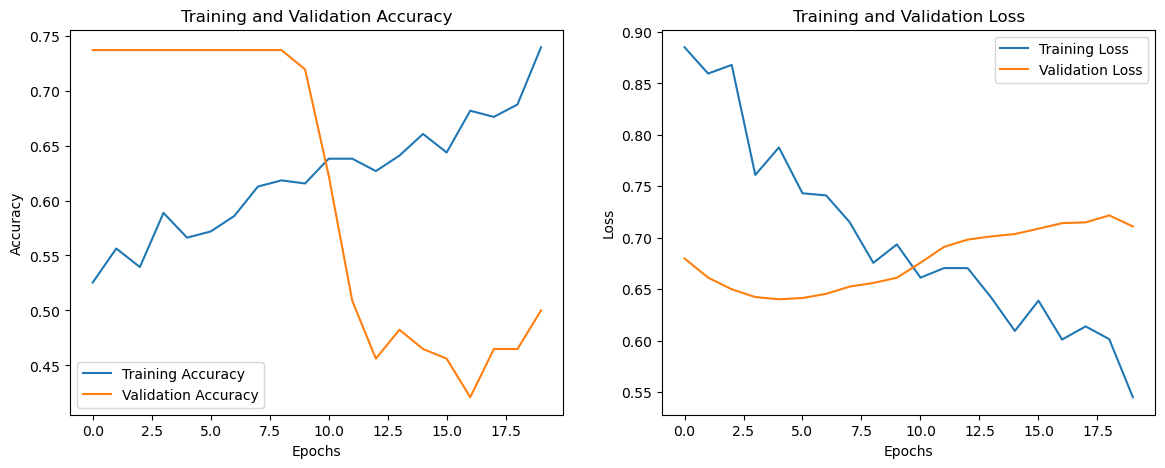

In [7]:
# Plot training and validation accuracy and loss
import matplotlib.pyplot as plt

def plot_training_curves(history):
    plt.figure(figsize=(14, 5))
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_training_curves(history)


## Evaluate the Model and Generate Metrics

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5136 - loss: 0.6903
Test Accuracy: 0.4965035021305084
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


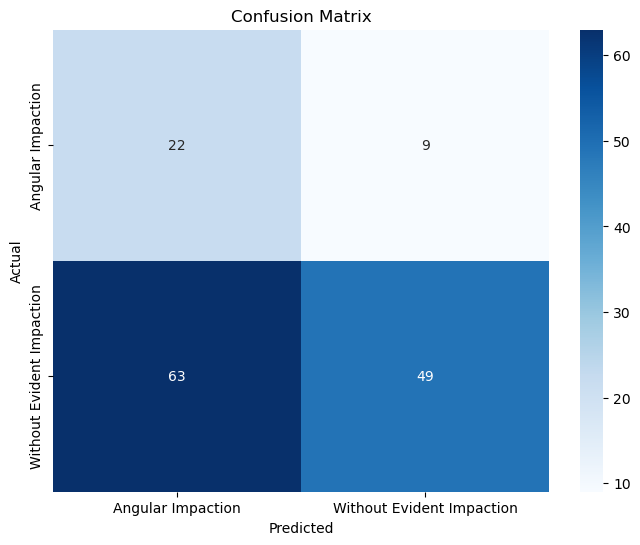

Classification Report:
                           precision    recall  f1-score   support

        Angular Impaction       0.26      0.71      0.38        31
Without Evident Impaction       0.84      0.44      0.58       112

                 accuracy                           0.50       143
                macro avg       0.55      0.57      0.48       143
             weighted avg       0.72      0.50      0.53       143

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


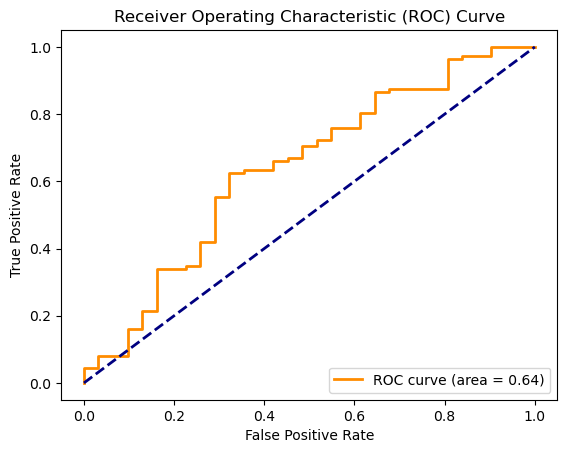

In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = cnn_model.evaluate(test_features, test_labels)
print("Test Accuracy:", test_accuracy)

# Generate predictions and evaluate the model
test_predictions = (cnn_model.predict(test_features) > 0.5).astype(int)

# Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

conf_matrix = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(test_labels, test_predictions, target_names=class_names))

# ROC Curve
fpr, tpr, _ = roc_curve(test_labels, cnn_model.predict(test_features))
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
